In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# get bank urls
banks = ['JPM/jpmorgan-chase','GS/goldman-sachs','BAC/bank-of-america','C/citigroup','MS/morgan-stanley']
revenue_url = 'https://www.macrotrends.net/stocks/charts/{}/revenue'
roi_url = 'https://www.macrotrends.net/stocks/charts/{}/roi'

def get_url(url):
    urls = []
    for i in banks:
        urls.append(url.format(i))
        
    return urls

get_url(roi_url)

['https://www.macrotrends.net/stocks/charts/JPM/jpmorgan-chase/roi',
 'https://www.macrotrends.net/stocks/charts/GS/goldman-sachs/roi',
 'https://www.macrotrends.net/stocks/charts/BAC/bank-of-america/roi',
 'https://www.macrotrends.net/stocks/charts/C/citigroup/roi',
 'https://www.macrotrends.net/stocks/charts/MS/morgan-stanley/roi']

In [11]:
# get bank revenue df
rev = []
for url, bank in zip(get_url(revenue_url), banks):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find_all('table')[1]
    data = []
    table_rows = table.find_all('tr')
    for row in table_rows:
        cells = row.find_all('td')
        if len(cells) > 0:
            data.append([cell.text.strip() for cell in cells])
    df = pd.DataFrame(data, columns=['Date', 'Revenue'])
    df['Bank'] = bank
    rev.append(df)

df_rev = pd.concat(rev, ignore_index=True)


In [13]:
df_rev['Revenue'] = df_rev['Revenue'].str.replace('$', '').str.replace(',', '').astype(float)
df_rev

/var/folders/8c/d3gzqcc518n52vmkdyccn0p40000gn/T/ipykernel_64046/3256412081.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_rev['Revenue'] = df_rev['Revenue'].str.replace('$', '').str.replace(',', '').astype(float)


,Date,Revenue,Bank
0,2023-03-31,54642.0,JPM/jpmorgan-chase
1,2022-12-31,47409.0,JPM/jpmorgan-chase
2,2022-09-30,40809.0,JPM/jpmorgan-chase
3,2022-06-30,34233.0,JPM/jpmorgan-chase
4,2022-03-31,32341.0,JPM/jpmorgan-chase
...,...,...,...
280,2010-03-31,9072.0,MS/morgan-stanley
281,2009-12-31,6718.0,MS/morgan-stanley
282,2009-09-30,8468.0,MS/morgan-stanley
283,2009-06-30,5197.0,MS/morgan-stanley


In [14]:
rev_pivot = df_rev.pivot(index='Date', columns='Bank', values='Revenue')

In [15]:
rev_pivot.index = pd.to_datetime(rev_pivot.index)


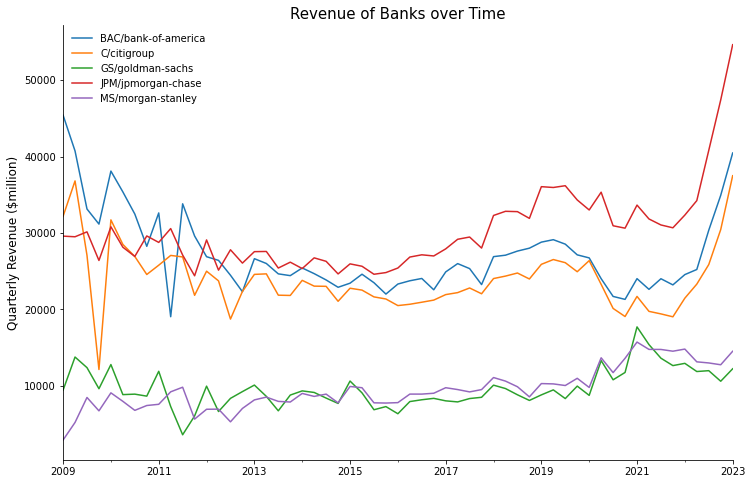

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

rev_pivot.plot(ax=ax)

ax.legend(frameon=False)

ax.set_xlabel('')
ax.set_ylabel('Quarterly Revenue ($million)', fontsize=12)
ax.set_title('Revenue of Banks over Time', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
# get bank roi df
roi = []
for url, bank in zip(get_url(roi_url), banks):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    data = []
    table_rows = table.find_all('tr')
    for row in table_rows:
        cells = row.find_all('td')
        if len(cells) > 0:
            data.append([cell.text.strip() for cell in cells])
    df_roi = pd.DataFrame(data, columns=['Date', 'TTM Net Income', 'LT Investments & Debt', 'ROI'])
    df_roi['Bank'] = bank
    roi.append(df_roi)

df_roi = pd.concat(roi, ignore_index=True)


In [ ]:
df_roi

In [ ]:
# merged df for banks
banking = pd.merge(df_rev, df_roi, how='inner', on=['Date','Bank'])

In [ ]:
banking

In [ ]:
fig, ax = plt.subplots()

for bank in banking:
    df_bank = banking[banking['Bank'] == bank]
    ax.plot(df_bank['Date'], df_bank['Revenue'], label=bank)

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.set_title('Revenue of Banks over Time')

plt.show()

In [ ]:
sp500 = pd.read_csv('sp500_index.csv')